# 1. Build an object detection model using pytorch

In [ ]:
import os
import io
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from PIL import Image

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
import torch.nn as nn
from torchvision import models
import torch.nn as nn
from torchvision import models
class ObjectDetection(nn.Module):
    def __init__(self):
        super(ObjectDetection, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        print(in_features)
        self.resnet.fc = nn.Identity()
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(2048, 61)
        self.bbox = nn.Linear(2048, 4)

    def forward(self, x):
       x = self.resnet(x)
       x = self.flatten(x)
       classifier = self.classifier(x)
       box = self.bbox(x)

       return classifier, box


In [ ]:
class CowstallDataset(Dataset):

    def __init__(self, dataset, img_dir, transform = None):
      super().__init__()
      self.dataset = dataset
      self.img_dir = img_dir
      self.transform = transform
      self.model = ObjectDetection().to(device)



    def __len__(self):
      return len(self.dataset)

    def __getitem__(self, idx):
      image_path = os.path.join(self.img_dir, self.dataset.iloc[idx,0])
      image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
      image = cv2.resize(image, (224,224))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /= 255.0
      image = self.transform(image)
      labels = torch.tensor(int(self.dataset.iloc[idx,5]))
      bound_boxes = self.dataset[['box_position_1', 'box_position_2', 'box_position_3', 'box_position_4']].values[idx]
      bound_boxes[2] = bound_boxes[0] + bound_boxes[2]
      bound_boxes[3] = bound_boxes[1] + bound_boxes[3]
      bound_boxes = torch.as_tensor(bound_boxes, dtype=torch.float32)

      return image, labels, bound_boxes


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/New folder/Stall_num_images/Train.csv").fillna(0)
df_test = pd.read_csv("/content/drive/MyDrive/New folder/Stall_num_images/Test.csv").fillna(0)

In [ ]:
img_dir = "/content/drive/MyDrive/Stall_num_images"
train_dataset = CowstallDataset(df_train, img_dir, train_transform)
test_dataset = CowstallDataset(df_test,img_dir,test_transform)
train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=True,
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2048
2048


In [ ]:
test_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.ToTensor()])

# 2. Train your model using [cow stall number datasets](https://github.com/YoushanZhang/Cow_stall_number)

In [ ]:
model = ObjectDetection().to(device)

2048


In [ ]:
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.MSELoss()

In [ ]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr


In [ ]:
params = [p for p in model.parameters() if p.requires_grad]

In [ ]:
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)

In [ ]:
# Learning rate scheduling
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [ ]:
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
epochs = 100

for e in range(epochs):
    running_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels, bound_boxes in train_data_loader:
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss1 = criterion_1(outputs[0], labels.to(device))
        loss2 = torch.sqrt(criterion_2(outputs[1], bound_boxes.to(device))) * 0.01
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        correct_train += sum(torch.argmax(i) == label for i, label in zip(outputs[0], labels))
        total_train += len(labels)

    train_acc = correct_train / total_train
    train_accs.append(train_acc)
    train_loss = running_loss / len(train_data_loader)
    train_losses.append(train_loss)

    correct_valid = 0
    total_valid = 0
    valid_loss = 0
    with torch.no_grad():
        for X, y, z in test_data_loader:
            outputs = model(X.to(device))
            correct_valid += sum(torch.argmax(i) == label for i, label in zip(outputs[0], y))
            total_valid += len(y)
            loss1 = criterion_1(outputs[0], y.to(device))
            loss2 = torch.sqrt(criterion_2(outputs[1], z.to(device))) * 0.01
            loss = loss1 + loss2
            valid_loss += loss.item()

    valid_acc = correct_valid / total_valid
    valid_accs.append(valid_acc)
    valid_loss /= len(test_data_loader)
    valid_losses.append(valid_loss)

    print(f"Epoch {e + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}%, Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc * 100:.2f}%")


Epoch 1/100, Train Loss: 5.4554, Train Acc: 20.54%, Val Loss: 5.0344, Val Acc: 23.75%
Epoch 2/100, Train Loss: 4.4396, Train Acc: 32.53%, Val Loss: 4.2634, Val Acc: 32.57%
Epoch 3/100, Train Loss: 3.4300, Train Acc: 54.80%, Val Loss: 3.4789, Val Acc: 47.13%
Epoch 4/100, Train Loss: 2.4359, Train Acc: 77.06%, Val Loss: 2.9424, Val Acc: 55.17%
Epoch 5/100, Train Loss: 1.6754, Train Acc: 90.98%, Val Loss: 2.4230, Val Acc: 63.60%
Epoch 6/100, Train Loss: 1.1716, Train Acc: 95.68%, Val Loss: 2.1711, Val Acc: 64.75%
Epoch 7/100, Train Loss: 0.8291, Train Acc: 98.08%, Val Loss: 1.7759, Val Acc: 71.65%
Epoch 8/100, Train Loss: 0.6618, Train Acc: 98.27%, Val Loss: 1.6876, Val Acc: 68.58%
Epoch 9/100, Train Loss: 0.5920, Train Acc: 98.37%, Val Loss: 1.7321, Val Acc: 67.43%
Epoch 10/100, Train Loss: 0.5723, Train Acc: 97.60%, Val Loss: 1.7874, Val Acc: 65.90%
Epoch 11/100, Train Loss: 0.6292, Train Acc: 96.55%, Val Loss: 1.5894, Val Acc: 70.50%
Epoch 12/100, Train Loss: 0.5969, Train Acc: 96.07%,

In [ ]:
file_path = os.path.join('/content/drive/MyDrive/Stall_num_images', 'model_85.pt')
torch.save(model, file_path)
model = torch.load('/content/drive/MyDrive/Stall_num_images/model_85.pt')

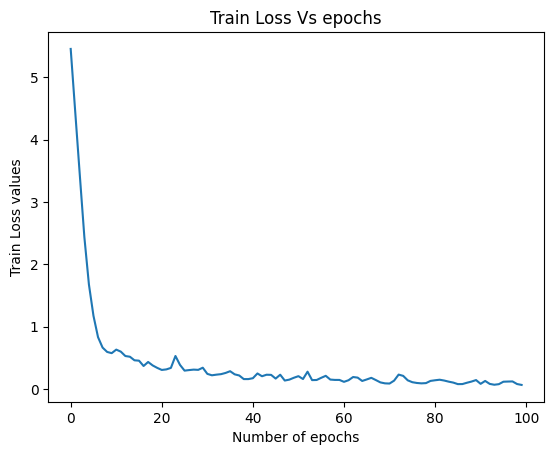

In [ ]:
epocs_run = [i for i in range(0,100)]
plt.plot(epocs_run, train_losses)
plt.title('Train Loss Vs epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Train Loss values')
plt.show()

# 4. Your results should be higher than 80%.

Train Loss: 0.0626, Train Acc: 100.00%, Val Loss: 0.7947, Val Acc: 85.06%

# 5. Write a four-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.

https://drive.google.com/drive/folders/1cN8CLvk38omU1SRo13yMKsDRXc3k0ZOD?usp=sharing
Latex file ad the mdel weights are over this link